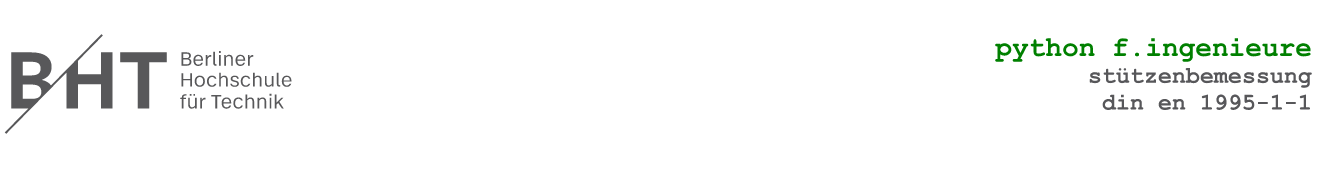

# Anwendungsbeispiel 1: Stützenbemessung

## Erstellung der Funktionen

Nachdem die Stützenbemessung nach der Theorie I. und II. Ordnung im Detail durchgesprochen wurde, können daraus Funktionen erstellt werden, die als Grundlage für das Stützenbemessungsprogramm dienen. 

### Ersatzstabverfahren

In [2]:
# Stützenbemessungsprogramm: Funktion - Ersatzstabverfahren
# Bibliotheken
from math import sqrt, pi  # Mathematische Funktionen

# Funktion
def ec5_63_esv(Lagerung, güte, L, b, h, N_ed, M_yd, M_zd, theta, f_c0k, f_myk, f_mzk, E, G_05, k_mod, gamma):

    # Vorbereitung
    # Listen
    L_M = [M_yd, M_zd]
    L_bh = [[b, h], [h, b]]
    L_fmk = [f_myk, f_mzk]
    L_k_crit = [1, 1]
    L_lamb = []
    L_lamb_rel = []
    L_ky = []
    L_kc = []
    L_sigma_md = []
    L_eta = []
    L_nw = []
    L_w = []
    L_I = []

    # Beiwert km
    if M_yd == 0 or M_zd == 0:
        L_km = [[1, 1], [1, 1]]
    else:
        L_km = [[1, 0.7], [0.7, 1]]

    # if-Abfrage zur Bestimmung von beta
    if Lagerung == 'Pendelstütze':
        beta = 1
    elif Lagerung == 'Kragstütze':
        beta = 2
    elif Lagerung in ['Eingespannt (o)', 'Eingespannt (u)']:
        beta = 0.7
    else:
        beta = 0.5

    # Berechnung
    # Knicklänge
    l_ef = L * beta
    e_0 = 0

    # Bemessungswerte der Festigkeit
    xi = k_mod / gamma
    f_c0d = f_c0k * xi  # $N/mm^2$ - Bemessungswert der Druckfestigkeit
    f_myd = f_myk * xi  # $N/mm^2$ - Bemessungswert der Biegefestigkeit
    f_mzd = f_mzk * xi  # $N/mm^2$ - Bemessungswert der Biegefestigkeit

    # Schleife für Momente um y- und z-Achse
    for n, M in enumerate(L_M):

        # Querschnittsparameter
        A = b * h  # $m^2$
        I = (L_bh[n][0] * L_bh[n][1]**3) / 12  # $m^4$ - FTM
        w = (L_bh[n][0] * L_bh[n][1]**2) / 6  # $m^3$ - Widerstandsmoment
        i = L_bh[n][1] / sqrt(12)  # $m$ - polares Trägheitsmoment
        L_w.append(w)
        L_I.append(I)

        # Knicken
        lamb = (beta * l_ef) / i  # Schlankheitsgrad
        lamb_rel = lamb / pi * sqrt(f_c0k / E)  # bezogene Schlankheit
        k_y = 0.5 * (1 + 0.1 * (lamb_rel - 0.3) + lamb_rel**2)  # Beiwert
        k_c = 1 / (k_y + sqrt(k_y**2 - lamb_rel**2))  # Knickbeiwert

        # Spannungen
        sigma_cd = N_ed / A  # $kN/m^2$ - Druckspannung
        sigma_md = M / w  # $kN/m^2$ - Biegespannung

        # Anhängen an Listen
        L_lamb.append(round(lamb, 2))
        L_lamb_rel.append(round(lamb_rel, 2))
        L_ky.append(round(k_y, 2))
        L_kc.append(round(k_c, 2))
        L_sigma_md.append(round(sigma_md, 2))

    # Kippen um starke Achse
    # Ermittlung des maßgebenden Widerstandsmoments
    index = L_w.index(max(L_w))
    w = L_w[index]
    b = L_bh[index][0]
    h = L_bh[index][1]
    f_mk = L_fmk[index]

    lamb_relm = sqrt(l_ef / (pi * b**2)) * sqrt(f_mk /
                                                sqrt(E * G_05))  # bez. Schlankheitsgrad

    # Kippbeiwert
    if lamb_relm <= 0.75:
        k_crit = 1
    elif lamb_relm > 0.75 and lamb_relm < 1.4:
        k_crit = 1.56 - 0.75 * lamb_relm
    elif lamb_relm > 1.4:
        k_crit = 1 / lamb_relm**2

    if index == 0:
        L_k_crit[0] = k_crit
        L_k_crit[1] = 1

    elif index == 1:
        L_k_crit[0] = 1
        L_k_crit[1] = k_crit

    # Listen für Nachweise
    L_Md = [M_yd, M_zd]
    lamb_rel = min(L_lamb_rel)
    L_pot = [[1, 2], [2, 1]]
    k_crit_index = L_w.index(max(L_w))

    # Schleife für Nachweise
    for n, M in enumerate(L_Md):
        # EC5 Abs. 6.2.4: Biegung m/o Druck ohne Knicken ohne Kippen
        if k_crit == 1 and lamb_rel < 0.3:
            eta = (sigma_cd / f_c0d)**2 + \
                L_km[n][0] * L_sigma_md[0] / f_myd + \
                L_km[n][1] * L_sigma_md[1] / f_mzd
            L_eta.append(round(eta, 2))
            nw = ('/')

        # EC5 Abs. 6.3.2: Biegung m/o Druck mit Knicken ohne Kippen
        elif k_crit == 1 and lamb_rel > 0.3:
            eta = (sigma_cd) / (f_c0d * L_kc[n]) + L_km[n][0] * \
                L_sigma_md[0] / f_myd + L_km[n][1] * L_sigma_md[1] / f_mzd
            L_eta.append(round(eta, 2))
            nw = ('Kn')

        # EC5 Abs. 6.3.3: Biegung m/o Druck mit Knicken und Kippen
        elif k_crit < 1 and lamb_rel < 0.3:
            eta = (sigma_cd) / (f_c0d * L_kc[n]) + (L_sigma_md[0] / (f_myd * L_k_crit[0])
                                                    )**L_pot[n][0] + (L_sigma_md[1] / (f_mzd * L_k_crit[1]))**L_pot[n][1]
            L_eta.append(round(eta, 2))
            nw = ('Kn/Ki')

        else:
            eta = 0
            L_eta.append(round(eta, 2))
            nw = ('N/A')

    return e_0, L_lamb, L_lamb_rel, L_ky, L_kc, k_crit, sigma_cd, L_sigma_md, L_eta, nw

### Theorie II. Ordnung

In [3]:
# Stützenbemessungsprogramm: Funktion - Theorie II. Ordnung
# Bibliotheken
from math import sqrt  # Mathematische Funktionen

# Funktion
def ec5_63_th2(Lagerung, güte, L, b, h, N_ed, M_yd, M_zd, theta, f_c0k, f_myk, f_mzk, E, k_mod, gamma, no_iter):

    # Listen
    L_eta = []

    # Bemessungswerte der Festigkeit
    xi = k_mod/gamma
    f_c0d = f_c0k*xi  # $N/mm^2$ - Bemessungswert der Druckfestigkeit
    f_myd = f_myk*xi  # $N/mm^2$ - Bemessungswert der Biegefestigkeit
    f_mzd = f_mzk*xi  # $N/mm^2$ - Bemessungswert der Biegefestigkeit

    # Beiwert k_m
    if M_yd == 0 or M_zd == 0:
        L_km = [[1, 1], [1, 1]]
    else:
        L_km = [[1, 0.7], [0.7, 1]]

    # if-Abfrage zur Bestimmung von beta
    if Lagerung == 'Pendelstütze':
        beta = 1
    elif Lagerung == 'Kragstütze':
        beta = 2
    elif Lagerung == 'Eingespannt (u/o)':
        beta = 0.7
    else:
        beta = 0.5

    # Ausmitte nach Theorie I. Ordnung
    l_ef = L*beta
    e_0 = round(theta*l_ef, 8)
    M_0 = e_0 * N_ed

    # Listen
    L_bh = [[b, h], [h, b], [b, h], [h, b]]
    L_e = [[e_0*1000], [0], [0], [e_0*1000]]
    L_M = [[M_yd+M_0], [M_zd], [M_yd], [M_zd+M_0]]
    L_e_total = [[e_0*1000], [0], [0], [e_0*1000]]
    L_M_total = [[M_yd+M_0], [M_zd], [M_yd], [M_zd+M_0]]
    L_sigma_mIId = []

    # Schleife 1: Durchlaufen von [M_yIId_imp, M_zIId, M_yIId, M_zIId_imp ]
    for n in range(4):

        # Querschnittsparameter
        A = b*h  # $m^2$
        I = (L_bh[n][0]*L_bh[n][1]**3)/12  # $m^4$ - FTM
        w = (L_bh[n][0]*L_bh[n][1]**2)/6  # $m^3$ - Widerstandsmoment
        i = L_bh[n][1]/sqrt(12)  # $m$ - polares Trägheitsmoment

        # Schleife 2: Schnittgrößenermittlung nach Theorie II. Ordnung
        for i in range(no_iter):

            # Ermittlung der Werte
            #e_i = (L_M[n][i]*l_ef**2)/(E*I*pi**2)
            e_i = (40*L_M[n][i]*L**2)/(E*I*384)
            M_i = e_i * N_ed

            # Anhängen der Werte in Listen
            L_e[n].append(round(e_i*1000, 1))
            L_M[n].append(M_i)
            e_total = sum(L_e[n])
            M_total = sum(L_M[n])
            L_e_total[n].append(round(e_total, 2))
            L_M_total[n].append(round(M_total, 2))

        # Spannungen
        sigma_mIId = L_M_total[n][-1]/w  # $kN/m^2$
        L_sigma_mIId.append(round(sigma_mIId, 2))

    # Ergebnisse der Schnittgrößenermittlung nach Theorie II. Ordnung
    # Verformungen und Momente
    L_e = [[L_e[0], L_e[1]], [L_e[2], L_e[3]]]
    L_M = [[L_M[0], L_M[1]], [L_M[2], L_M[3]]]
    L_e_total = [[L_e_total[0], L_e_total[1]], [L_e_total[2], L_e_total[3]]]
    L_M_total = [[L_M_total[0], L_M_total[1]], [L_M_total[2], L_M_total[3]]]

    # Spannungen
    sigma_cd = N_ed/A  # $kN/m^2$ - Druckspannung
    L_sigma_mIId = [[L_sigma_mIId[0], L_sigma_mIId[1]],
                    [L_sigma_mIId[2], L_sigma_mIId[3]]]

    # Schleife für y- und z-Achse
    for i in range(2):

        # Nachweis
        eta = (sigma_cd/f_c0d)**2 + \
            L_km[i][0]*L_sigma_mIId[i][0]/f_myd + \
            L_km[i][1]*L_sigma_mIId[i][1]/f_mzd
        L_eta.append(round(eta, 6))

    # maximale Ausnutzung
    eta_max = max(L_eta)
    index = L_eta.index(eta_max)

    return L_e[index], L_M[index], L_e_total[index], L_M_total[index], sigma_cd, L_sigma_mIId[index], eta_max, index

___
Berliner Hochschule für Technik (BHT) | Konstruktiver Hoch- und Ingenieurbau (M.Eng.) <br>
Ingenieurholzbau | Prof. Dr. Jens Kickler | Cal Mense 914553 | September 2022